<a href="https://colab.research.google.com/github/alvaroferrerrizzo/Employee-Churn-Predictive-Model/blob/master/Reby/ml_projects/ride_predict_ML_keras_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#following: https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding
import os 
import matplotlib.pylab as plt
import pandas as pd

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

# Plotting
import matplotlib.pyplot as plt
#---
from google.cloud import bigquery

%matplotlib inline

In [ ]:
from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.4.1


In [ ]:
from google.colab import auth
auth.authenticate_user()

%load_ext google.colab.data_table
project_id = 'reby-cloud'
client = bigquery.Client(project=project_id)

In [2]:
!rm -rf ./logs/ 

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
logdir

'logs/fit/20210411-053230'

In [ ]:
def get_keras_dataset(df):
    X = {str(col) : np.array(df[col]) for col in df.columns}
    return X

In [ ]:
def plot_history(history):
    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(211)
    
    plt.xlabel('Epoch')
    plt.ylabel('loss, acc')
    
    # Losses
    ax.plot(history.epoch, history.history['loss'], label='Train LOSS')
    ax.plot(history.epoch, history.history['val_loss'], label='Val LOSS')
    ax.plot(history.epoch, history.history['accuracy'], label ='Train Accuracy')
    ax.plot(history.epoch, history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    
    # Plot the learning_rate
    if 'lr' in history.history:
        ax = plt.subplot(212)
        plt.ylabel('Learning rate')
        ax.plot(history.epoch, history.history['lr'], label='learning_rate')
        plt.legend()
    plt.show()
    plt.close(fig)

In [ ]:
df_main = client.query('''

    SELECT 
    met_ride,
    h3,
    rfm.segment,
    hour,
    week_day,
    area,
    demand_met,
    credit,
    promotion,
    plan_activated,
    total_rides_before_mv,
    avg_ride_distance,
    diff_last_ride,
    payment_times,
    total_payment_amount/100 as total_payment_amount,
    diff_mv_ts_day,
    historic_conversion,
    latest_kick_scooter_rides,
    latest_motorcycle_rides,
    latest_bicycle_rides,
    rides_last_30_days,
    kick_scooter_nearby,
    avg_battery_level_kick_scooter,
    bici_nearby,
    avg_battery_level_bici,
    moto_nearby	avg_battery_level_moto
from `reby-cloud.reby_demand_eu.demand_ride_analysis` ra
left join `reby-cloud.reby_marketing_eu.rfm_users_30_days` as rfm
  on ra.user_id = rfm.user_id and date(ra.mv_timestamp) = date(rfm.date)
where date(mv_timestamp) > '2020-09-01'

''' ).to_dataframe()

In [3]:
df_main = pd.read_csv('test_ml_3.csv')
df_main=df_main.drop(columns={'Unnamed: 0'})
#df_main.to_csv('test_ml_3.csv')

In [29]:
df_all = df_main.copy()

In [30]:
#we get rid of rows with no previous ride
df_all = df_all[df_all['diff_last_ride'].notna()]
df_all = df_all[df_all['segment'].notna()]
df_all = df_all[df_all['diff_mv_ts_day'].notna()]

In [ ]:
#df_all.isna().sum()

met_ride                               0
h3                                     0
segment                                0
hour                                   0
week_day                               0
area                                   0
demand_met                             0
credit                                 0
promotion                              0
plan_activated                         0
total_rides_before_mv                  0
avg_ride_distance                    189
diff_last_ride                         0
payment_times                          0
total_payment_amount                   0
diff_mv_ts_day                         0
historic_conversion                    0
latest_kick_scooter_rides              0
latest_motorcycle_rides                0
latest_bicycle_rides                   0
rides_last_30_days                     0
kick_scooter_nearby                    0
avg_battery_level_kick_scooter    277362
bici_nearby                            0
avg_battery_leve

In [25]:
#df_all = df_all.loc[(df_all['area']=='Barcelona') & (df_all['total_rides_before_mv']>=5)]
df_all = df_all.loc[df_all['total_rides_before_mv']>=1]

In [31]:
print(df_all.shape)
df_all.reset_index(drop=True, inplace=True)

(609047, 26)


In [32]:
df_all.head()

,met_ride,h3,segment,hour,week_day,area,demand_met,credit,promotion,plan_activated,total_rides_before_mv,avg_ride_distance,diff_last_ride,payment_times,total_payment_amount,diff_mv_ts_day,historic_conversion,latest_kick_scooter_rides,latest_motorcycle_rides,latest_bicycle_rides,rides_last_30_days,kick_scooter_nearby,avg_battery_level_kick_scooter,bici_nearby,avg_battery_level_bici,avg_battery_level_moto
0,no,8839446015fffff,risk,16,Thu,Barcelona,not_met,1816,0,False,79,3382.288807,3.0,7,91.76,3.0,0.451977,0,10,0,48,0,NaN,0,NaN,0
1,yes,8839446033fffff,new heavy,19,Thu,Barcelona,not_met,0,906,False,6,2988.744050,6.0,0,0.00,0.0,0.500000,0,6,0,6,0,NaN,0,NaN,0
2,yes,88394460c7fffff,new heavy,19,Thu,Barcelona,not_met,0,906,False,6,2988.744050,6.0,0,0.00,6.0,0.444444,0,6,0,6,0,NaN,0,NaN,0
3,no,8839446013fffff,mid,17,Tue,Barcelona,met,0,226,False,7,3307.146429,0.0,0,0.00,0.0,0.294118,0,7,0,7,0,NaN,0,NaN,3
4,yes,8839446013fffff,mid,8,Tue,Barcelona,met,0,549,False,6,3218.228200,1.0,0,0.00,0.0,0.258065,0,6,0,6,0,NaN,0,NaN,4


In [ ]:
df_all.groupby(['demand_met','met_ride']).size()

demand_met  met_ride
met         no          172453
            yes         204202
not_met     no          154586
            yes          77806
dtype: int64

In [ ]:
df_all.groupby(['demand_met']).size()

demand_met
met        376655
not_met    232392
dtype: int64

In [ ]:
df_all.groupby(['met_ride']).size()

met_ride
no     327039
yes    282008
dtype: int64

In [33]:

df_all=df_all.drop(columns={'avg_battery_level_kick_scooter','avg_battery_level_bici','avg_battery_level_moto'})
#df_all=df_all.drop(columns={'area'})

In [34]:
#telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes", 0:"No"})
#categorical data
categorical_cols = ['segment', 'area']
#categorical_cols = ['segment', 'week_day']

#change met_ride, demand_met, plan_activated
binary_cols = ['met_ride', 'demand_met', 'plan_activated']

met_ride = {'yes': 1,'no': 0}
demand_met = {'met': 1,'not_met': 0}
plan_activated = {'True': 1,'False': 0}

df_all['met_ride'] = df_all['met_ride'].apply(lambda x: 1 if x == 'yes' else 0)
df_all['demand_met'] = df_all['demand_met'].apply(lambda x: 1 if x == 'met' else 0)
df_all['plan_activated'] = df_all['plan_activated'].apply(lambda x: 1 if x == 'True' else 0)

#import pandas as pd
df_categorical = pd.get_dummies(df_all, columns = categorical_cols, drop_first = True)

In [35]:
df_sa_h3 = df_main.groupby(['h3','area']).size().reset_index().rename(columns={0:'count'})
h3_area_dict = {}
for idx,rw in df_sa_h3.iterrows():
    h3_area_dict[rw.h3] = rw.area

In [36]:
numeric_cols = df_categorical.select_dtypes(include='number').columns.to_list()

target_col = ['met_ride']

ignored_cols = []
categorical_cols = df_categorical.select_dtypes(include='object').columns.to_list()
categorical_cols = [col for col in categorical_cols if col not in target_col + ignored_cols]

In [37]:
len(numeric_cols)

39

In [ ]:

"""
for col in categorical_cols:
    le = LabelEncoder()
    df_categorical[col] = le.fit_transform(df_categorical[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping) 
"""
#telcom['Churn'] = telcom['Churn'].map({'Yes' : 1, 'No' : 0})

{'8818596961fffff': 0, '8818596969fffff': 1, '881859696dfffff': 2, '88185ba601fffff': 3, '88185ba609fffff': 4, '88185ba60dfffff': 5, '88185ba641fffff': 6, '88185ba643fffff': 7, '88185ba645fffff': 8, '88185ba647fffff': 9, '88185ba649fffff': 10, '88185ba64bfffff': 11, '88185ba64dfffff': 12, '88185ba655fffff': 13, '88185ba659fffff': 14, '88185ba65dfffff': 15, '88185ba661fffff': 16, '88185ba663fffff': 17, '88185ba669fffff': 18, '88185ba66bfffff': 19, '88185ba66dfffff': 20, '88185bb483fffff': 21, '88185bb487fffff': 22, '88185bb48bfffff': 23, '88185bb49dfffff': 24, '88185bb4a3fffff': 25, '88185bb4a5fffff': 26, '88185bb4a7fffff': 27, '88185bb4abfffff': 28, '88185bb4b1fffff': 29, '88185bb4b3fffff': 30, '88185bb4b5fffff': 31, '88185bb4b7fffff': 32, '88185bb4bdfffff': 33, '88185bb591fffff': 34, '88185bb593fffff': 35, '88185bb597fffff': 36, '88185bb59bfffff': 37, '88185bb5bbfffff': 38, '881e832051fffff': 39, '881e832059fffff': 40, '881e83205bfffff': 41, '881e832203fffff': 42, '881e83220bfffff': 4

In [38]:
#Impute missing values
"""
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.NaN, strategy="mean")
df_categorical["avg_ride_distance"] = imp.fit_transform(df_categorical[["avg_ride_distance"]]).ravel()
"""
df_categorical["avg_ride_distance"].fillna((df_categorical["avg_ride_distance"].mean()), inplace=True)

In [39]:
scaler = StandardScaler()
df_categorical[['credit', 'promotion','avg_ride_distance']] = scaler.fit_transform(df_categorical[['credit', 'promotion','avg_ride_distance']])

In [40]:
#df_categorical.isna().sum()
df_categorical.head()

,met_ride,h3,hour,week_day,demand_met,credit,promotion,plan_activated,total_rides_before_mv,avg_ride_distance,diff_last_ride,payment_times,total_payment_amount,diff_mv_ts_day,historic_conversion,latest_kick_scooter_rides,latest_motorcycle_rides,latest_bicycle_rides,rides_last_30_days,kick_scooter_nearby,bici_nearby,segment_loyal,segment_mid,segment_new,segment_new heavy,segment_non-active,segment_occasional,segment_resurect,segment_risk,area_Bergamo,area_Caserta,area_Florencia,area_Gijón,area_Lecce,area_Napoles,area_No Service Area,area_Sitges,area_Tarragona,area_Terrassa,area_ZFranca,area_Zaragoza
0,0,8839446015fffff,16,Thu,0,0.459354,-0.039651,0,79,0.980977,3.0,7,91.76,3.0,0.451977,0,10,0,48,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,8839446033fffff,19,Thu,0,-0.276006,0.023396,0,6,0.694652,6.0,0,0.00,0.0,0.500000,0,6,0,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,88394460c7fffff,19,Thu,0,-0.276006,0.023396,0,6,0.694652,6.0,0,0.00,6.0,0.444444,0,6,0,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,8839446013fffff,17,Tue,1,-0.276006,-0.023924,0,7,0.926307,0.0,0,0.00,0.0,0.294118,0,7,0,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,8839446013fffff,8,Tue,1,-0.276006,-0.001447,0,6,0.861614,1.0,0,0.00,0.0,0.258065,0,6,0,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
X = df_categorical.drop(columns={'met_ride'})
y = df_categorical['met_ride']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)

(408061, 40)
(200986, 40)


In [ ]:
y_train.unique()

array([1, 0])

In [42]:
#def preproc(X_train, X_val):
embed_cols=[i for i in categorical_cols]
dict_name = {}
for i in embed_cols:
    print(i,df_categorical[i].nunique())

input_list_train = []
input_list_val = []
#input_list_test = []

#the cols to be embedded: rescaling to range [0, # values)
for c in categorical_cols:
    print(c)
    raw_vals = np.unique(X_train[c])
    val_map = {}
    for i in range(len(raw_vals)):
        val_map[raw_vals[i]] = i       
    input_list_train.append(X_train[c].map(val_map).values)
    input_list_val.append(X_test[c].map(val_map).fillna(0).values)
    #input_list_test.append(X_test[c].map(val_map).fillna(0).values)
    dict_name[c] = val_map
#the rest of the columns
other_cols = [c for c in X_train.columns if (not c in embed_cols)]
input_list_train.append(X_train[other_cols].values)
input_list_val.append(X_test[other_cols].values)
#input_list_test.append(X_test[other_cols].values)

input_list_train, input_list_val#, input_list_test

h3 553
week_day 7
h3
week_day


([array([ 94, 484, 441, ..., 216, 273, 290]),
  array([0, 3, 6, ..., 4, 6, 0]),
  array([[23.        ,  0.        , -0.27600577, ...,  0.        ,
           0.        ,  0.        ],
         [19.        ,  0.        ,  0.08843484, ...,  0.        ,
           0.        ,  1.        ],
         [20.        ,  0.        , -0.30232648, ...,  0.        ,
           0.        ,  1.        ],
         ...,
         [17.        ,  1.        , -0.27600577, ...,  0.        ,
           0.        ,  0.        ],
         [ 9.        ,  1.        , -0.27600577, ...,  0.        ,
           0.        ,  0.        ],
         [17.        ,  0.        , -0.20514232, ...,  0.        ,
           0.        ,  0.        ]])],
 [array([516.,  96., 348., ..., 253., 505., 250.]),
  array([4, 6, 3, ..., 6, 2, 6]),
  array([[20.        ,  1.        ,  0.02769473, ...,  0.        ,
           0.        ,  1.        ],
         [ 7.        ,  1.        ,  0.08033615, ...,  0.        ,
           0.        ,

In [43]:
len(input_list_train[1])

408061

In [44]:
a = dict(dict_name['h3'])
list_=[]

for k,v in a.items():
    combo = [k,h3_area_dict[k]]
    list_.append(combo)

In [45]:
list_[:3]

[['8818596961fffff', 'Gijón'],
 ['8818596969fffff', 'Gijón'],
 ['881859696dfffff', 'Gijón']]

In [ ]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorica Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorica Variable: h3 Unique Categories: 539 Embedding Size: 50
Categorica Variable: week_day Unique Categories: 7 Embedding Size: 4


In [ ]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_h3
Input_week_day


In [46]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
    print(cat_emb_name)
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=['number']).columns.tolist()),))
#input_numeric = Input(shape=(38,))
print(len(X_train.select_dtypes(include=['number']).columns.tolist()))
#embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(input_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(300, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

h3_Embedding
week_day_Embedding
38


In [47]:
import pydot_ng as pydot

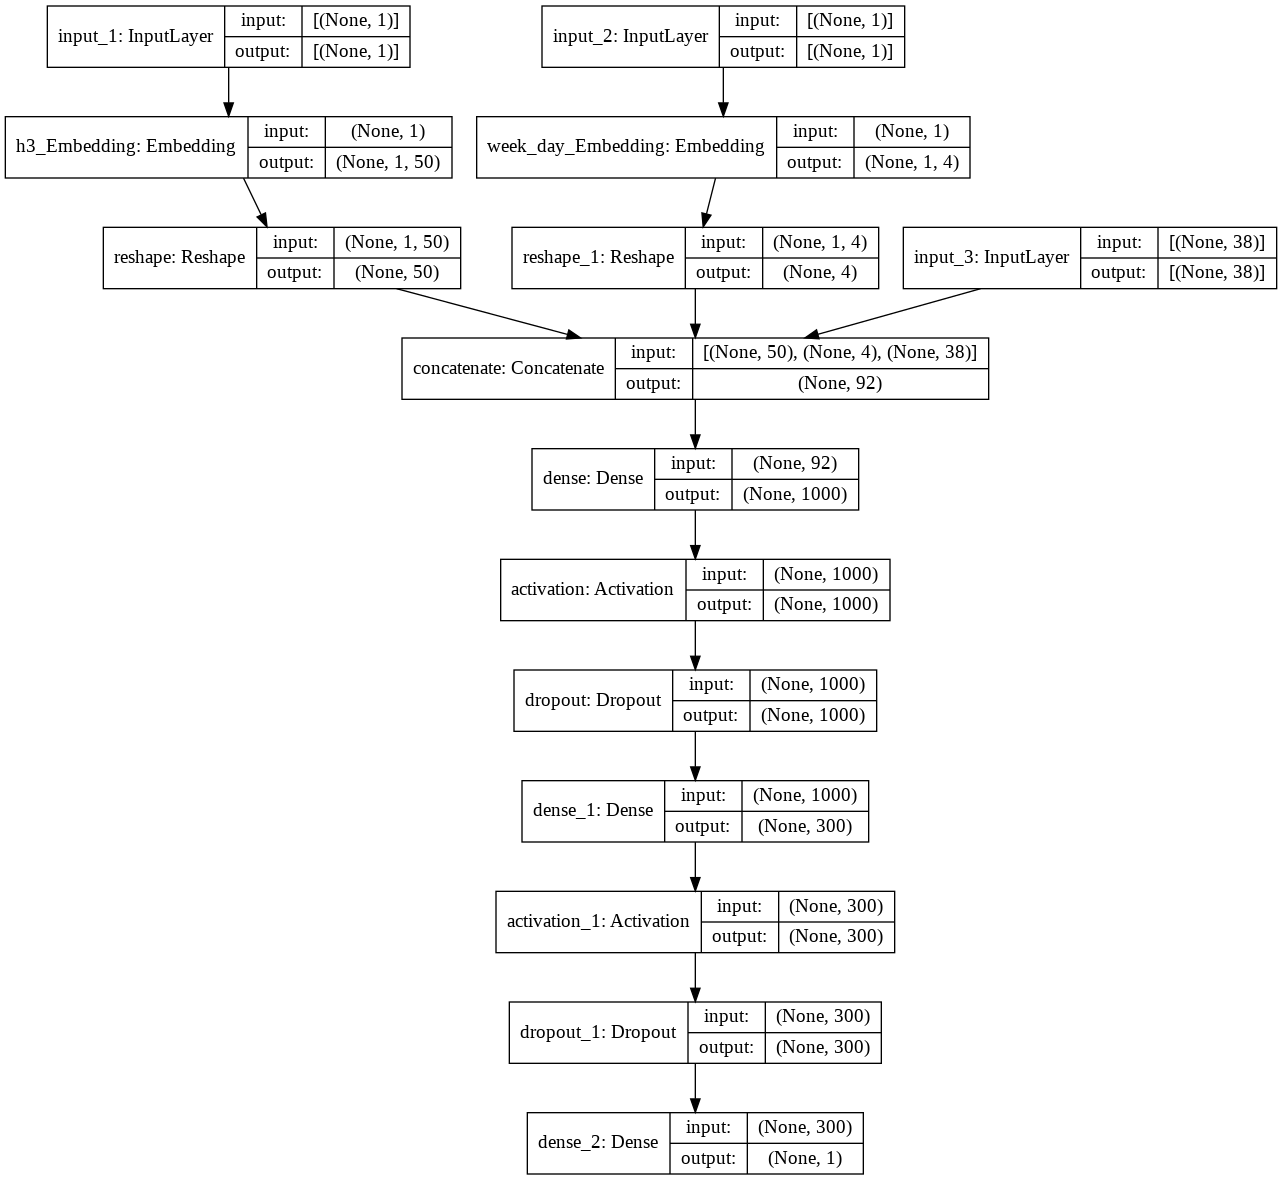

In [48]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
#X_train_list,X_val_list = preproc(X_train,X_test)

In [49]:
history = model.fit(
    input_list_train,y_train,validation_data=(input_list_val,y_test) ,
    #callbacks=[tensorboard_callback],
    epochs =  20 , batch_size = 10000)

Epoch 1/20
41/41 [==============================] - 5s 32ms/step - loss: 1.9997 - accuracy: 0.5582 - val_loss: 0.6599 - val_accuracy: 0.6146
Epoch 2/20
41/41 [==============================] - 1s 19ms/step - loss: 0.6561 - accuracy: 0.6136 - val_loss: 0.6392 - val_accuracy: 0.6357
Epoch 3/20
41/41 [==============================] - 1s 19ms/step - loss: 0.6365 - accuracy: 0.6386 - val_loss: 0.6197 - val_accuracy: 0.6567
Epoch 4/20
41/41 [==============================] - 1s 19ms/step - loss: 0.6182 - accuracy: 0.6560 - val_loss: 0.5985 - val_accuracy: 0.6695
Epoch 5/20
41/41 [==============================] - 1s 19ms/step - loss: 0.6011 - accuracy: 0.6715 - val_loss: 0.5814 - val_accuracy: 0.6837
Epoch 6/20
41/41 [==============================] - 1s 19ms/step - loss: 0.5853 - accuracy: 0.6815 - val_loss: 0.5616 - val_accuracy: 0.6945
Epoch 7/20
41/41 [==============================] - 1s 19ms/step - loss: 0.5688 - accuracy: 0.6921 - val_loss: 0.5516 - val_accuracy: 0.7002
Epoch 8/20
41

In [ ]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
print(model.get_layer('h3_Embedding').get_weights()[0])

[[-0.2235655   0.1512368   0.15067956 ...  0.22915171  0.17648377
  -0.22018589]
 [-0.23114865 -0.10101129 -0.00044273 ...  0.08416288 -0.00483582
  -0.225928  ]
 [ 0.06975544  0.05074583 -0.02427555 ...  0.11966282  0.0328956
  -0.06645448]
 ...
 [-0.12978451  0.07573412  0.08272915 ...  0.00203323 -0.01893084
   0.05627939]
 [-0.03531975  0.1091314   0.03636815 ... -0.01605757  0.00949536
   0.11225805]
 [-0.12825568  0.1546834   0.12246139 ...  0.05708611  0.11970674
  -0.09810632]]


In [50]:
emb_layer = model.get_layer('h3_Embedding')
(w,) = emb_layer.get_weights()

In [ ]:
print(w[90])

[ 0.15474461 -0.02887305 -0.08045731  0.01776337 -0.04368843 -0.04265194
 -0.00940242 -0.07859115  0.05412883 -0.10201757  0.01311546  0.1944821
 -0.07725983  0.00157431  0.04300236  0.12462098 -0.16483214  0.05270889
  0.03298869 -0.0770871   0.01897499  0.05473979  0.05941738 -0.02431231
  0.0127031  -0.02739444  0.01629099  0.20734903 -0.0369265  -0.19078116
 -0.02884058 -0.16738237  0.02775524 -0.07624375  0.00659901  0.04055737
 -0.03130688  0.00744027  0.13383044  0.04513079 -0.00293639 -0.03286119
 -0.11240687  0.04513862  0.06552753  0.20123947  0.01179506 -0.09460197
 -0.05084961  0.03488151]


In [ ]:
f = {
        'h3' : 'count'
}

g = df_categorical.groupby(['h3'])
v1 = g.agg(f)

In [ ]:
filter_h3 = v1.loc[v1.h3 > 1000]

In [ ]:
len(filter_h3.index.to_list())

174

Tensorboard - Projections

In [51]:
list_v = list_
head = [['h3','area']]
list_v = head + list_v
len(list_v)

540

In [52]:
#https://stackoverflow.com/questions/55343375/mapping-entity-embeddings-back-to-the-original-categorical-values

weights = model.get_layer('h3_Embedding').get_weights()[0]
vocab = np.array(list_v)#vectorize_layer.get_vocabulary()

In [ ]:
len(vocab)

540

In [ ]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  #if index == 0:
  #  continue  # skip 0, it's padding.
  #print(index)
  vec = weights[index]
  word_ = list_v[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  #out_m.write('\t'.join([str(x) for x in word_]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [54]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(weights):
  #if index == 0:
  #  continue  # skip 0, it's padding.
  #print(index)
  vec = weights[index]
  #word_ = list_v[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  #out_m.write('\t'.join([str(x) for x in word_]) + "\n")
  #out_m.write(word + "\n")

for index, word in enumerate(vocab):
  #if index == 0:
  #  continue  # skip 0, it's padding.
  #print(index)
  #vec = weights[index]
  word_ = list_v[index]
  #out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write('\t'.join([str(x) for x in word_]) + "\n")
  #out_m.write(word + "\n")

out_v.close()
out_m.close()

In [ ]:
list_v[0]

array(['8818596961fffff', 'Gijón'], dtype='<U15')

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Save the model

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
filepath = './saved_model'
save_model(model, filepath)

INFO:tensorflow:Assets written to: ./saved_model/assets


Load the model

In [ ]:
model = load_model(filepath, compile = True)

In [55]:
b = []
for i in range(3):
    print(i)
    a = input_list_train[i][1]
    b.append(a)
#np.array(input_list_train[0][0],input_list_train[0][1],input_list_train[0][2])

0
1
2


In [110]:
predict_list = []
j = 9
a = [input_list_train[0][j]]
c = [input_list_train[1][j]]
d = [input_list_train[2][j]]

In [111]:
predict_list.append(np.array(a))
predict_list.append(np.array(c))
predict_list.append(np.array(d))

In [112]:
input = [predict_list]
#input

Do predictions on new data

In [113]:
#b = nparray(b).astype('float32')
predictions = model.predict(input)
print(predictions)

[[0.79531676]]


In [109]:
y_train.iloc[0:10]

538552    1
424107    1
498475    0
249229    1
375200    1
359723    0
58734     1
274351    1
585076    0
524953    1
Name: met_ride, dtype: int64